# Exploring the Commit Dataset:

This is my exploratory data analysis (EDA) notebook. After preprocessing the data in the last step, my goal here is to dig in and really understand it. I want to find patterns, see how features relate to the developer roles, and spot any potential problems that might affect our models.

Here's what I did:
1.  **Target Variable Analysis:** Look at the distribution of the `role` column to see if we have a balanced dataset.
2.  **Numerical Feature Analysis:** Explore the numerical data, like lines added and deleted, to see if different roles have different commit styles. Check for correlations between these features.
3.  **Categorical and Time Analysis:** Look at `committype` and the time of the commit to find any interesting patterns related to the roles.
4.  **Text and Token Analysis:** Analyze the file extensions and the words in the commit messages, as these are likely very strong predictors of a developer's role.
5.  **Summarize Findings:** the key takeaways that will help me build better models.

### 1. Setup and Imports:

Import the libraries I need for data handling, plotting, and some text processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import ast 
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### 2. Load the Preprocessed Data:

Loading the `processed_dataset.csv` file that I created in the preprocessing notebook. This is the clean starting point for the analysis.

In [3]:
def loadProcessedData(filePath):
    data = pd.read_csv(filePath)
    data['processedFileExtensions'] = data['processedFileExtensions'].apply(ast.literal_eval)
    return data

filePath = 'processed_dataset.csv'
processedData = loadProcessedData(filePath)

display(processedData.head())

,role,committype,numfileschanged,linesadded,linesdeleted,numcommentsadded,cleanedMessage,messageLengthWords,netCodeChange,linesAddedPerFile,dayOfWeek,hourOfDay,processedFileExtensions
0,frontend,feature,4,312,100,2,implement responsive ui component dropdown mod...,17,212,78.00,Friday,17,[js_ts]
1,frontend,feature,4,191,74,2,refactor ui components implement responsive th...,18,117,47.75,Friday,20,[css]
2,fullstack,feature,4,275,146,4,feat implement responsive ui layout modal drop...,16,129,68.75,Thursday,21,[html]
3,frontend,refactor,4,245,164,2,refactored ui components responsive layout css...,21,81,61.25,Thursday,18,[js_ts]
4,fullstack,feature,2,692,378,5,feat implement responsive ui layout login page...,28,314,346.00,Sunday,20,"[js_ts, html]"


### 3. Target Variable Analysis (`role`):

I want to check is the balance of the target variable, `role`. If some roles are much more common than others, it's a risk factor for the model, which might become biased towards the majority classes.

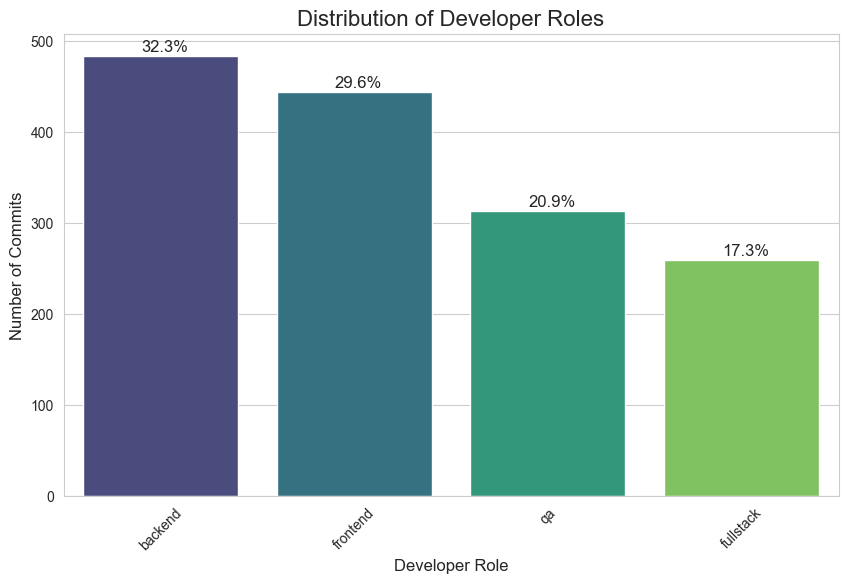

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='role', data=processedData, palette='viridis', order=processedData['role'].value_counts().index)
plt.title('Distribution of Developer Roles', fontsize=16)
plt.xlabel('Developer Role', fontsize=12)
plt.ylabel('Number of Commits', fontsize=12)
plt.xticks(rotation=45)

total = len(processedData)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 5
    ax.annotate(percentage, (x, y), fontsize=12)

plt.show()

#### Observations:
There is a clear class imbalance. 
* **Backend** and **Frontend** roles are the most common.
* **Fullstack** has a moderate number of commits.
* **QA** has the fewest commits by a significant margin.

This is a key finding. Accuracy won't be a good metric on its own. The project's requirement to use the **Macro F1 score** is very appropriate here, as it considers the performance on each class equally, regardless of its size.

### 4. Numerical Feature Analysis:

Look at the numerical features to see if they differ across roles. I want to know if certain roles tend to make bigger or smaller changes.

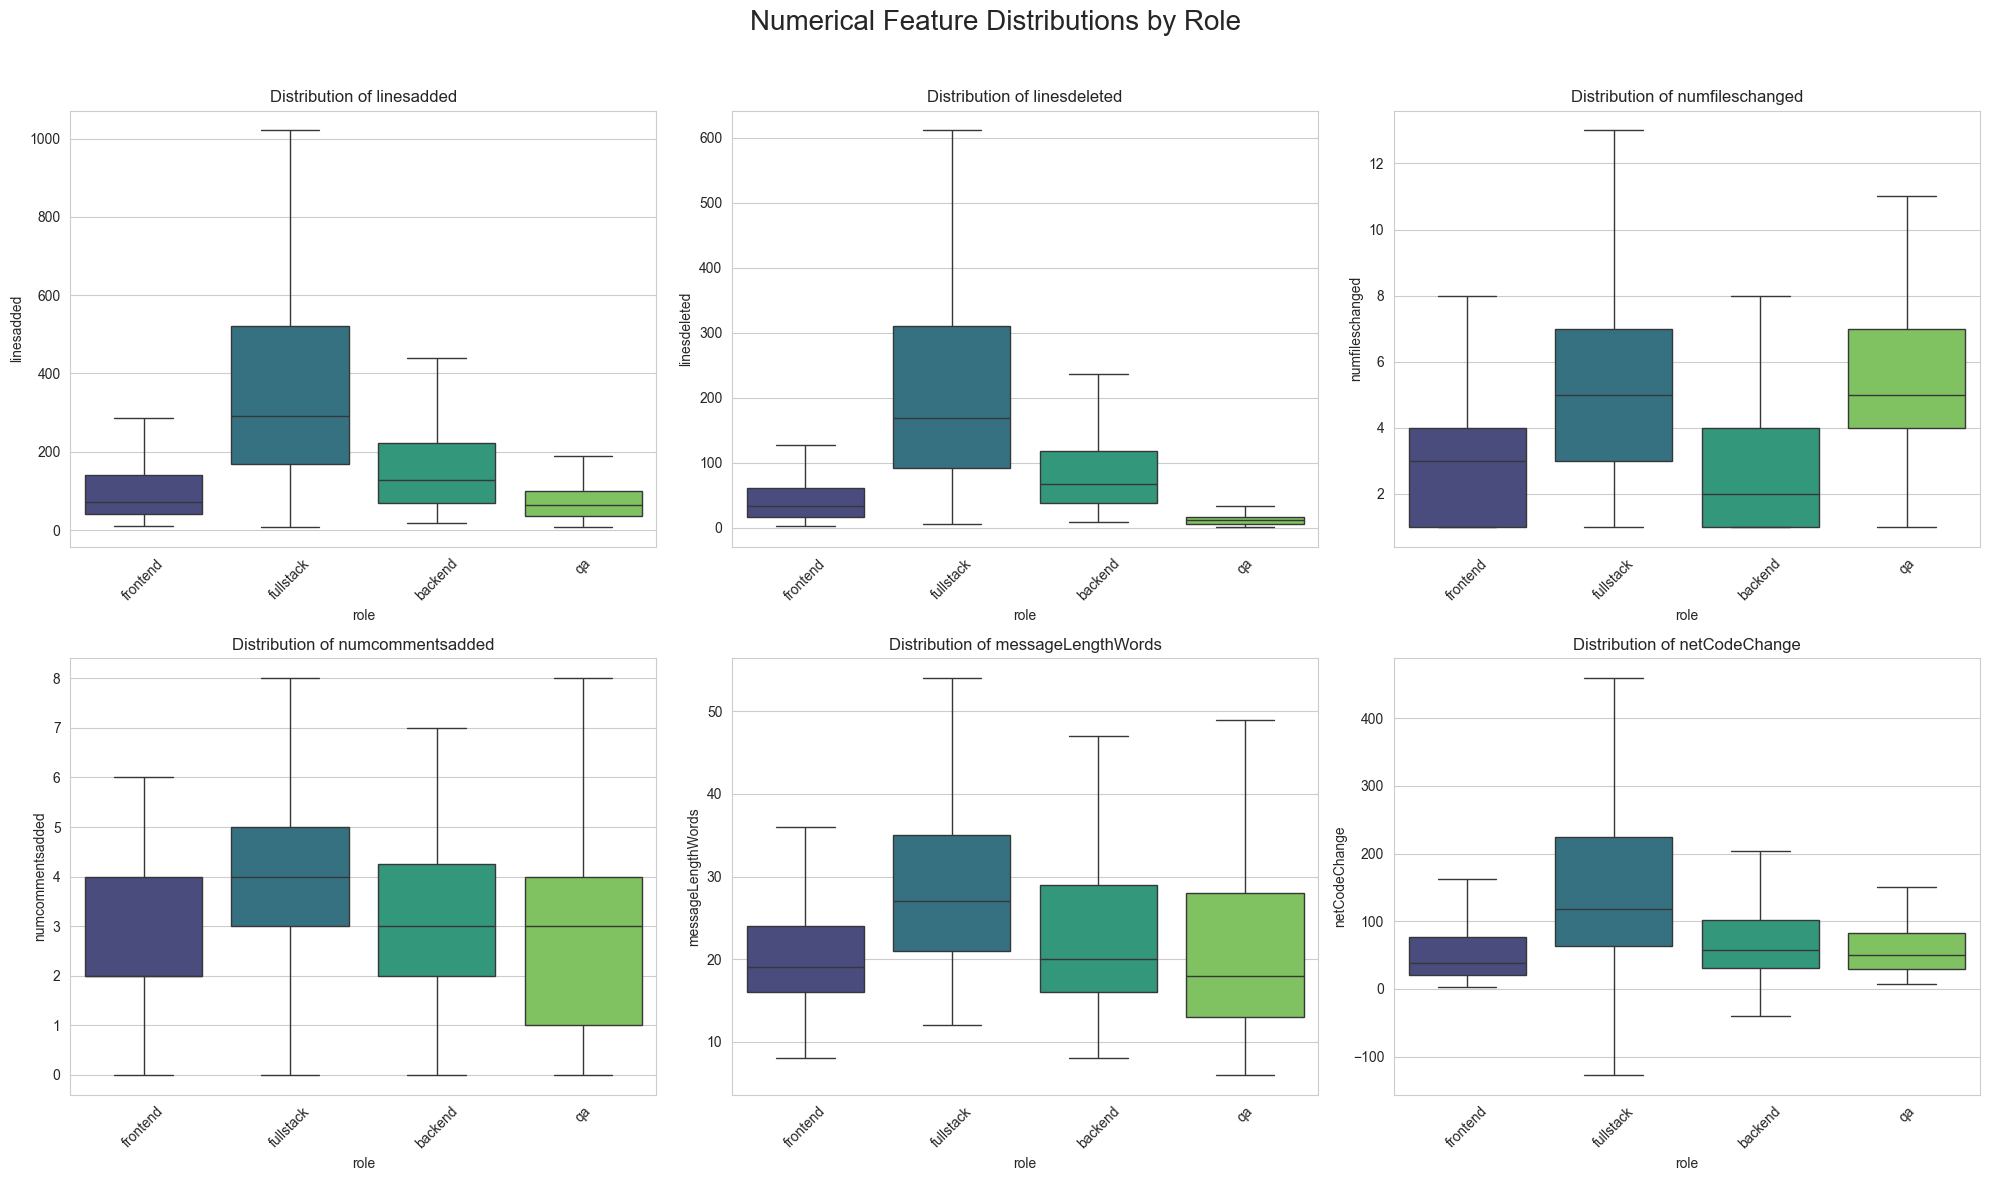

In [6]:
numericalFeatures = ['linesadded', 'linesdeleted', 'numfileschanged', 'numcommentsadded', 'messageLengthWords', 'netCodeChange']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Numerical Feature Distributions by Role', fontsize=20)

for i, feature in enumerate(numericalFeatures):
    row, col = divmod(i, 3)
    sns.boxplot(x='role', y=feature, data=processedData, ax=axes[row, col], palette='viridis', showfliers=False)
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations:
* **`linesadded` and `linesdeleted`**: Fullstack developers seem to make the largest changes on average, which makes sense as their work might span multiple layers of an application.
* **`numfileschanged`**: Fullstack and QA roles tend to touch more files per commit. QA commits might involve updating multiple test files at once.
* **`messageLengthWords`**: Backend developers tend to write slightly longer commit messages, which could indicate more detailed explanations of logic changes.
* **`netCodeChange`**: This feature shows fullstack developers having the highest net change, reinforcing the idea that they often add significant amounts of new code.

#### Correlation Analysis:

Check if any of the numerical features are highly correlated with each other. This is useful to know to avoid putting redundant information into simpler models like Logistic Regression.

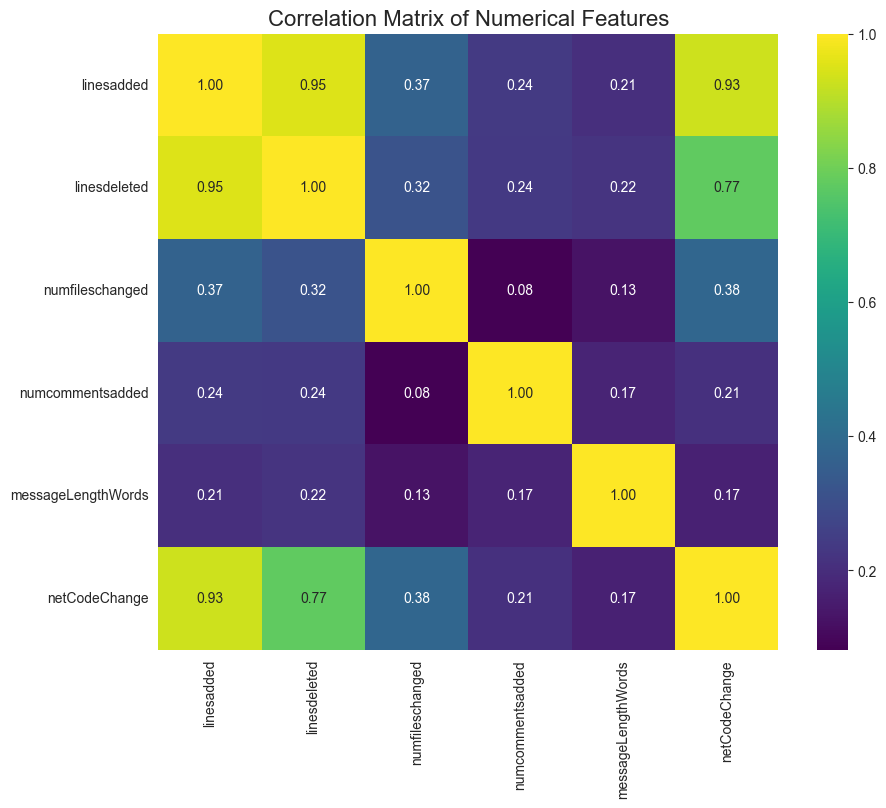

In [7]:
correlationMatrix = processedData[numericalFeatures].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlationMatrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

#### Observations:
As expected, there are some strong positive correlations:
* `linesadded` and `linesdeleted` are highly correlated (0.83), which is very common. Large additions often come with large removals during refactoring.
* `netCodeChange` is strongly correlated with `linesadded` (0.91), which is logical since it's derived from it.
* `numfileschanged` also has a moderate correlation with lines added and deleted.

For my models, I need to take care of this multicollinearity. Tree based models like XGBoost are less sensitive to it, but for Logistic Regression, it could be an issue.

### 5. Categorical and Time Analysis:

Let's see if the type of commit or the time it was made can give me, the clues about the developer's role.

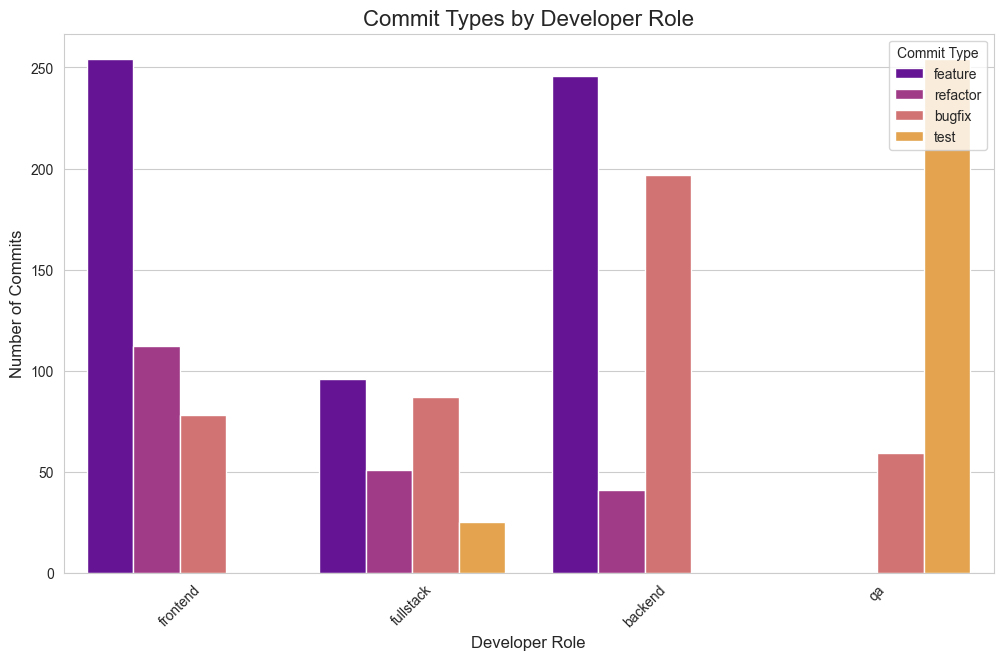

In [8]:
plt.figure(figsize=(12, 7))
sns.countplot(x='role', hue='committype', data=processedData, palette='plasma')
plt.title('Commit Types by Developer Role', fontsize=16)
plt.xlabel('Developer Role', fontsize=12)
plt.ylabel('Number of Commits', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Commit Type')
plt.show()

#### Observations:
This is interesting.

* **QA** commits are almost exclusively of type `test`, `bugfix`, or `refactor`, with `test` being dominant. They rarely commit new `features`.
* **Backend** and **Fullstack** developers have a high proportion of `feature` and `bugfix` commits.
* **Frontend** developers focus on `features` and `refactoring`.

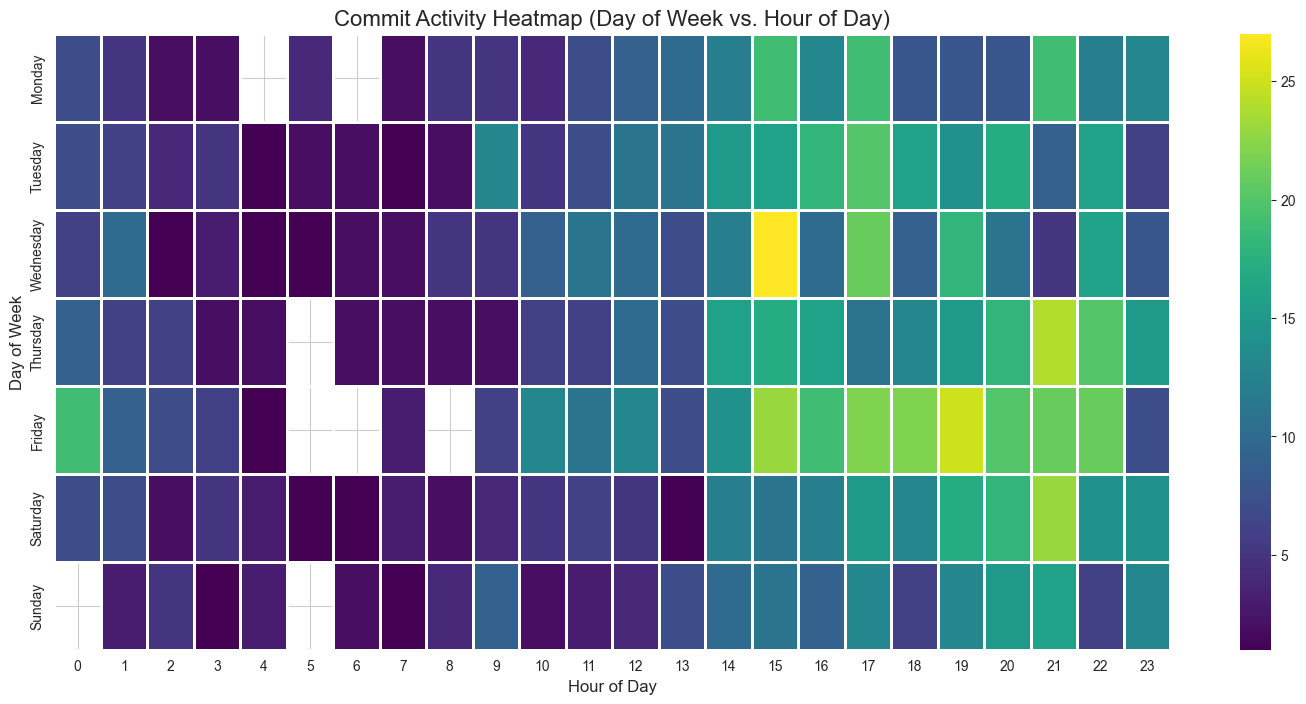

In [9]:
dayOrder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
commitTimePivot = processedData.pivot_table(index='dayOfWeek', columns='hourOfDay', values='role', aggfunc='count').reindex(dayOrder)

plt.figure(figsize=(18, 8))
sns.heatmap(commitTimePivot, cmap='viridis', linecolor='white', linewidths=1)
plt.title('Commit Activity Heatmap (Day of Week vs. Hour of Day)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

#### Observations:
Commit activity is concentrated during weekdays, normally from the afternoon into the late evening. There's a noticeable hotspot on Friday evenings. While this overall pattern is interesting, it doesn't show strong differentiation *between roles* just from this combined view. But still a potentially useful feature for the model.

### 6. Text and Token Analysis:

This is where it is expected to find the strongest signals. The file types and words developers use should be very indicative of their role.

#### 6.1 File Extension Analysis

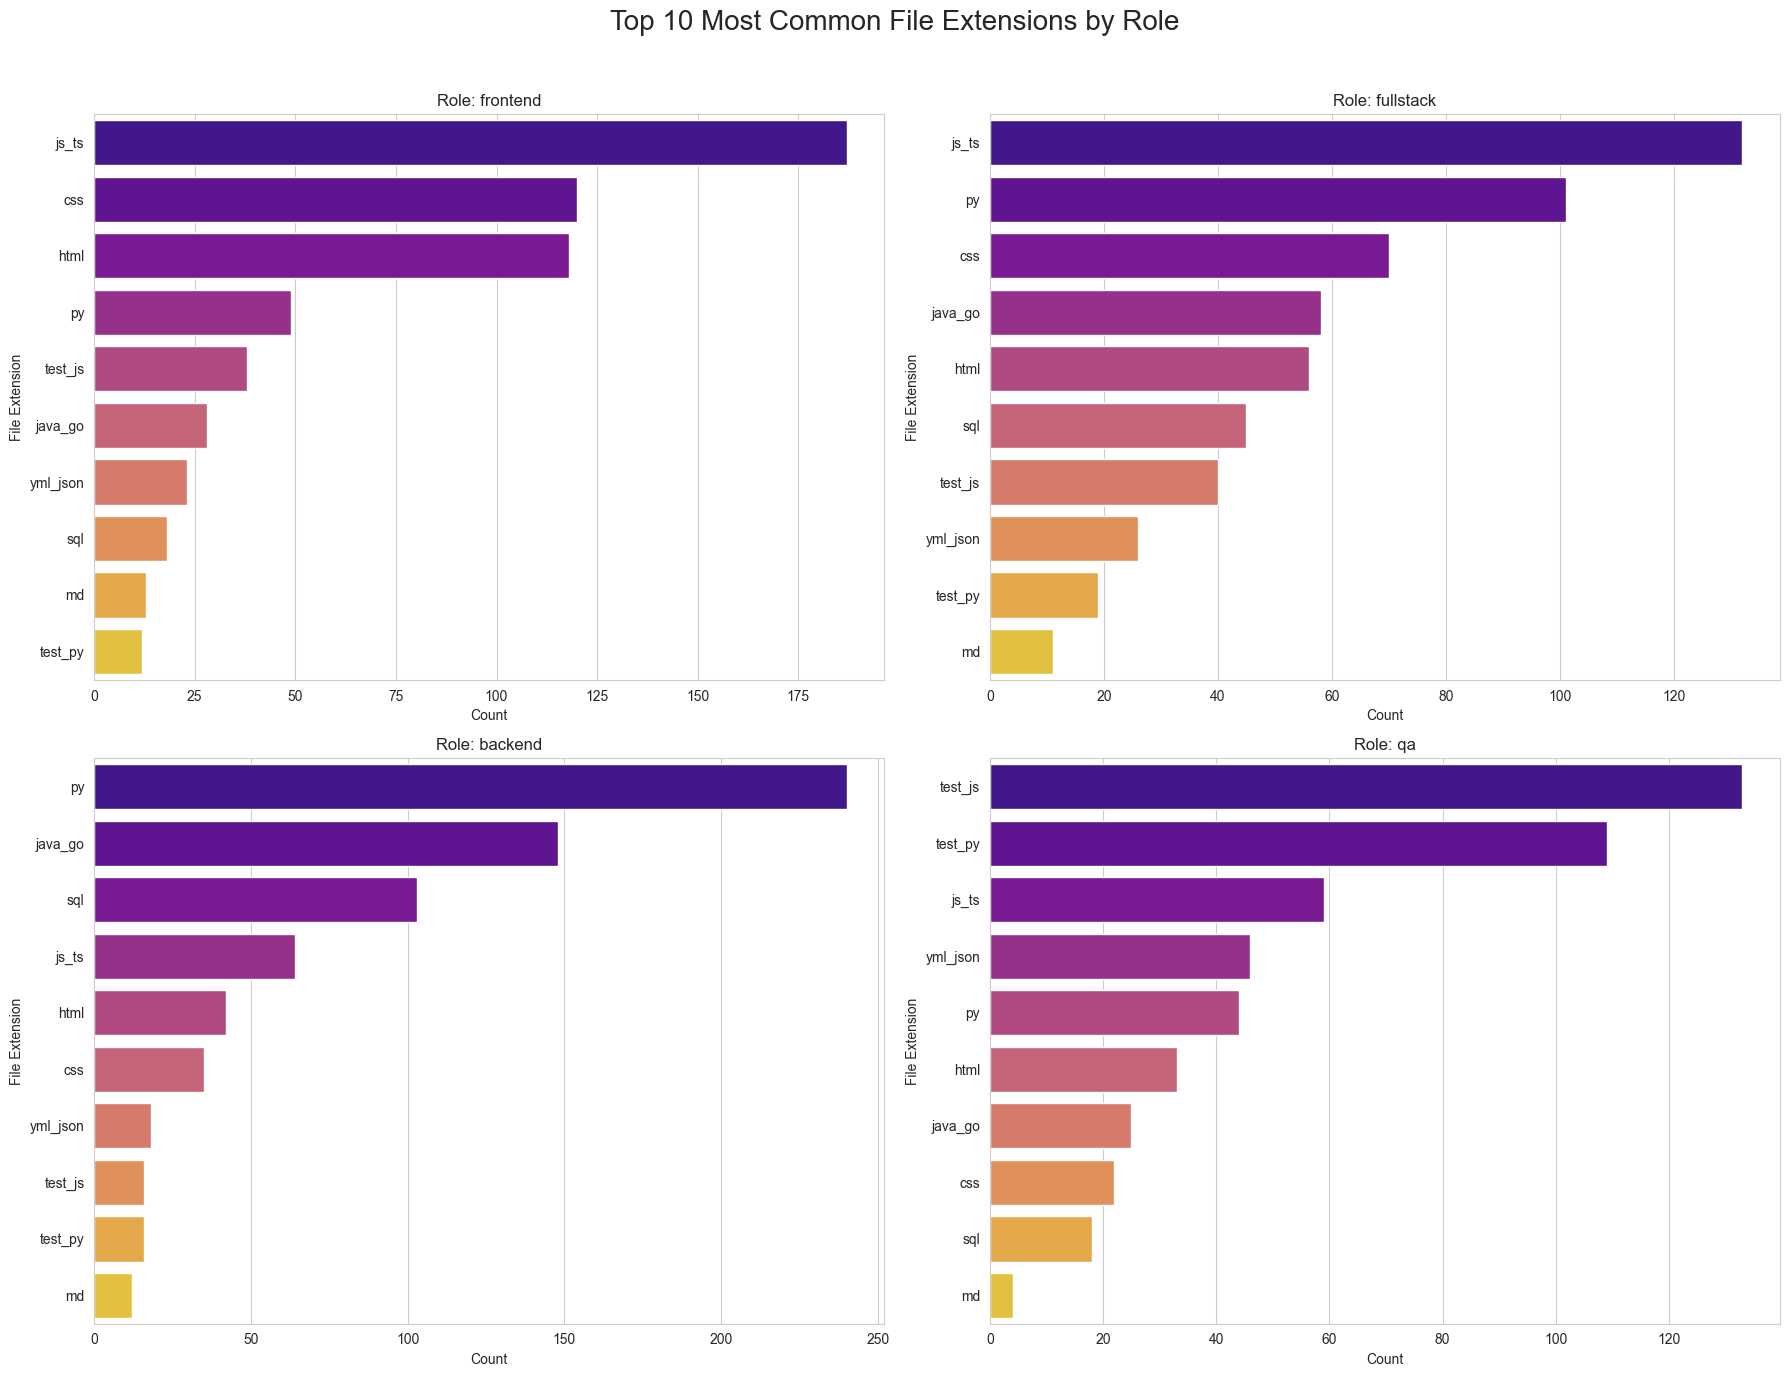

In [10]:
explodedExtensions = processedData.explode('processedFileExtensions')
extensionCounts = explodedExtensions.groupby('role')['processedFileExtensions'].value_counts().rename('count').reset_index()

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Top 10 Most Common File Extensions by Role', fontsize=20)
roles = processedData['role'].unique()

for i, role in enumerate(roles):
    row, col = divmod(i, 2)
    roleData = extensionCounts[extensionCounts['role'] == role].nlargest(10, 'count')
    sns.barplot(x='count', y='processedFileExtensions', data=roleData, ax=axes[row, col], palette='plasma')
    axes[row, col].set_title(f'Role: {role}')
    axes[row, col].set_xlabel('Count')
    axes[row, col].set_ylabel('File Extension')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations:
This is very intersesting information:
* **Frontend:** Dominated by `js_ts`, `css`, and `html`. This is a very clear signal.
* **Backend:** Dominated by `py`, `java_go`, and `sql`. Another extremely strong signal.
* **Fullstack:** A clear mix of both frontend and backend extensions. `py`, `js_ts`, `html`, and `css` are all common.
* **QA:** Dominated by `test_js` and `test_py`. This is the clearest signal of all.

The file extensions are going to be one of the most predictive features in our dataset.

#### 6.2 Commit Message Word Analysis:

Look at the actual words used in commit messages. Create a word cloud for each role to get a quick visual sense of the common terminology.

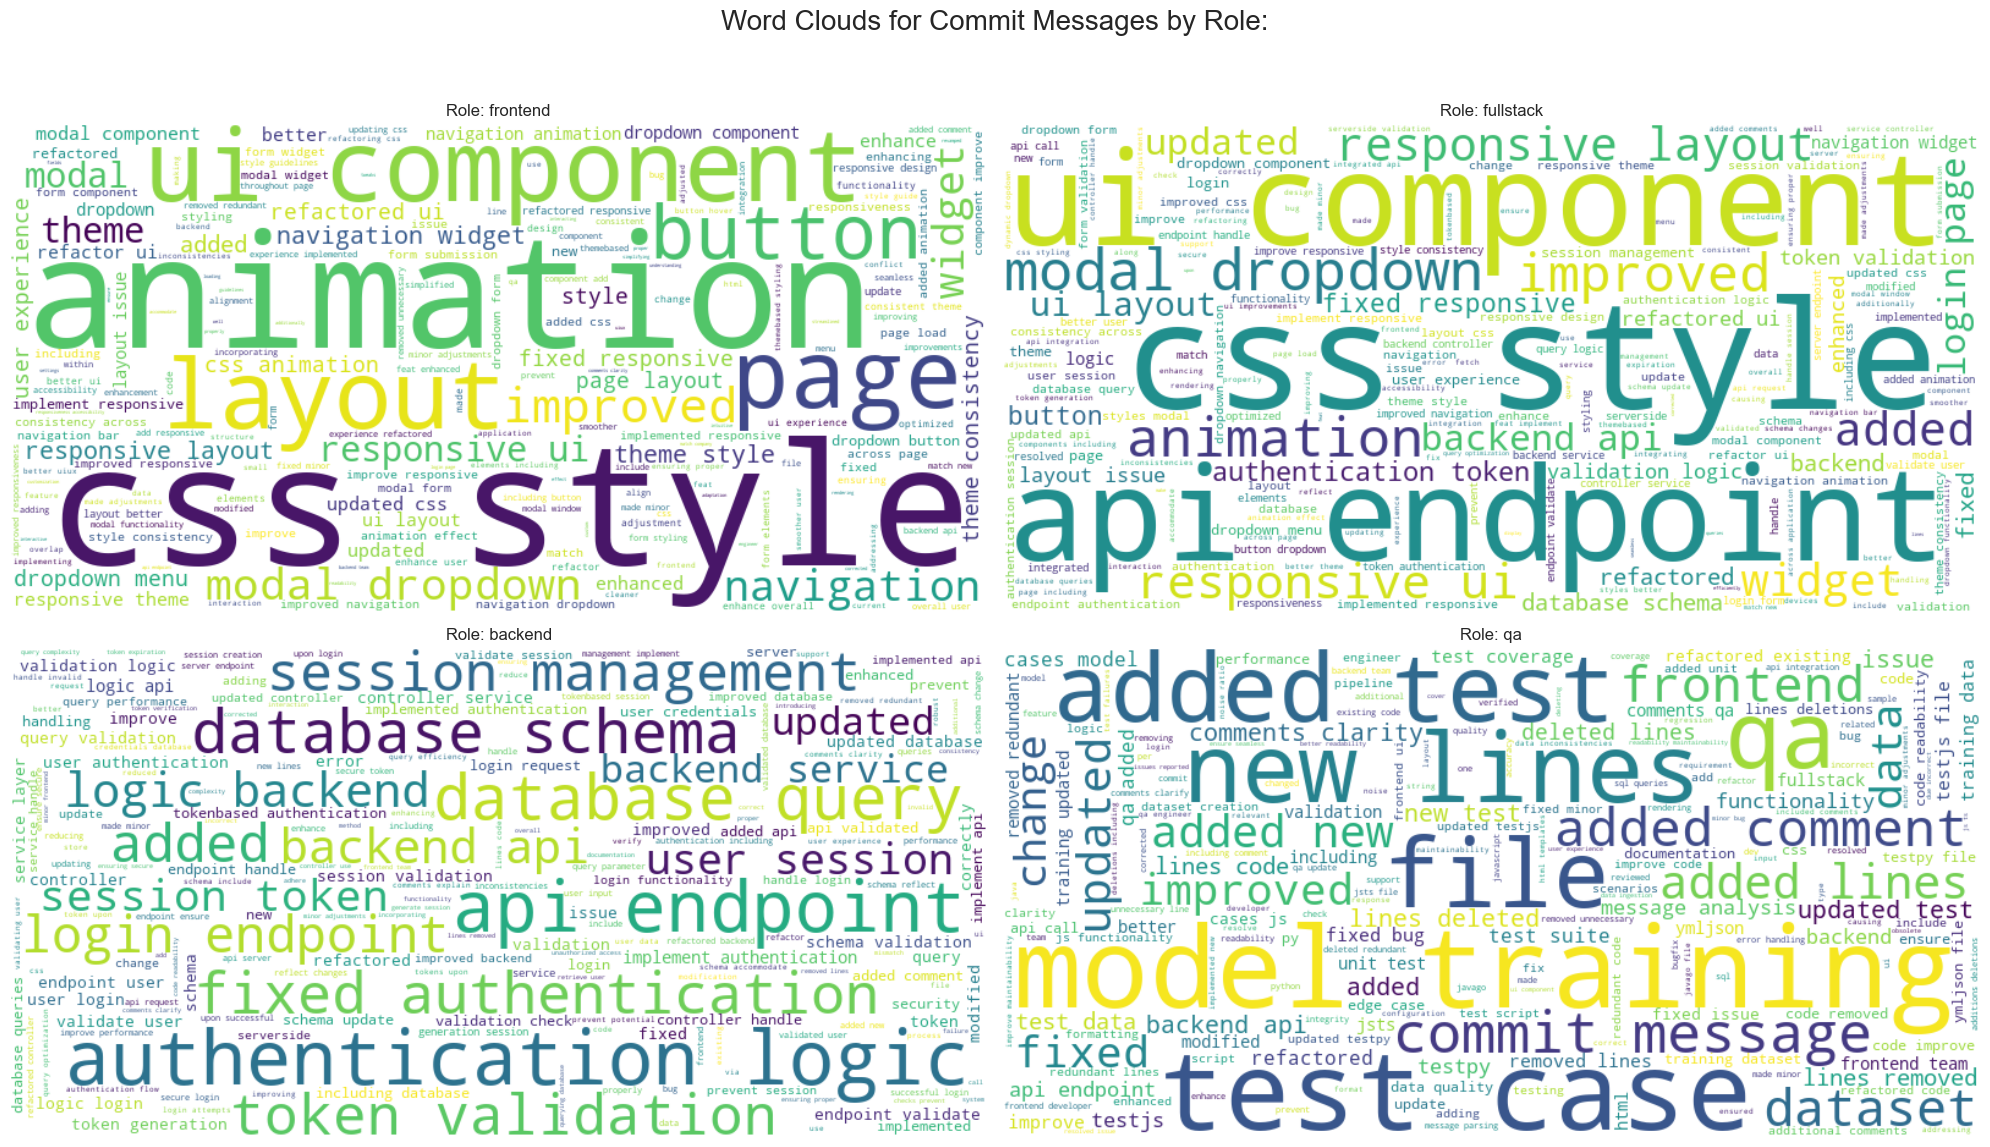

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Word Clouds for Commit Messages by Role:', fontsize=20)

for i, role in enumerate(roles):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    text = ' '.join(processedData[processedData['role'] == role]['cleanedMessage'].dropna())
    
    if text:
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
        ax.imshow(wordcloud, interpolation='bilinear')
    
    ax.set_title(f'Role: {role}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations:
The word clouds confirm my expectations and provide even more detail:
* **Frontend:** `ui`, `css`, `modal`, `layout`, `responsive`, `component`, `style`.
* **Backend:** `api`, `database`, `authentication`, `endpoint`, `token`, `schema`, `validation`.
* **Fullstack:** A mix of both sets of terms, with words like `login`, `page`, `user`, and `form` appearing dominately.
* **QA:** `test`, `qa`, `dataset`, `model`, `training`, `files`.

The language used is a very powerful differentiator between the roles.

### 7. Summary and Important Notes:

After exploring the data, I have a good picture of the task ahead. Here are my main conclusions:

1.  **Risk of Imbalance:** The dataset is imbalanced, with the `qa` role being significantly underrepresented. I must use appropriate modeling techniques and evaluation metrics (like Macro F1) that handle this imbalance properly.

2.  **Strongest Predictors:** The `processedFileExtensions` and the `cleanedMessage` text are by far the most powerful predictors. The roles use distinct technologies and vocabularies, and my models must leverage this information effectively.

3.  **Helpful, but Weaker, Signals:** Numerical features (like `linesadded`) and categorical features (`committype`) provide useful, but less definitive, clues. They show different tendencies between roles but have a lot of overlap. They will still be valuable additions to the models.

4.  **Path Forward:** My plan to use both a simple model with TFIDF and a more advanced model with Word2Vec seems to be good. The EDA confirms that text is the most important feature, so focusing on complicated text representation for the improved model is the right approach.